## Analyzing models fits

## Objective
* Perform cross validation on 4 different models for this dataset
* Visualize uncertainty in Bayesian inference of 10000 samples

In [35]:
# Standard imports
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

import pymc3 as pm

Loading gapminder data and selecting year 1985

In [23]:
gapminder = pd.read_csv('gapminder.csv')
gdata = gapminder.query('year == 1985')

In [24]:
# Refactored plotting so that it works on arbitrary datasets.
def sc(data):
    return 1e-6 * data.population, data.region.map({'Africa': '#A4A8D1', 
                                                    'Europe': '#F8C192',                                               
                                                    'America': '#32DE8A',
                                                    'Asia': '#A64253'}
                                                  )

def plotdata(data=gdata):
    size, colors = sc(data)
    data.plot.scatter('age5_surviving','babies_per_woman',
                      c=colors,s=size,linewidths=0.5,edgecolor='k',alpha=0.5)
                      
def plotfit(fit,data=gdata):
    plotdata(data)

    size, colors = sc(data)
    plt.scatter(data.age5_surviving,fit.predict(data),
               c=colors,s=30,linewidths=0.5,edgecolor='k',marker='D')

Cross-validation function

In [27]:
# Generic function in terms of formula and response variable
def cross_validate(data,formula,response,n=100):
    ret = []
    
    for i in range(n):
        # First shuffle the data
        shuffled = data.sample(len(data))
        
        training = shuffled.iloc[:len(data)//2]
        testing = shuffled.iloc[len(data)//2:]
        
        trained = smf.ols(formula,data=training).fit()
        
        # A little extra work to get mean squared error of model on testing data
        resid = trained.predict(testing) - testing[response]
        df = len(testing) - trained.df_model - 1
        mse = np.sum(resid**2) / df
    
        ret.append(mse)
    
    return np.mean(ret)

Models to compare against

In [30]:
# Models to compare
f_groupmeans = 'babies_per_woman ~ -1 + region'
f_surviving = 'babies_per_woman ~ -1 + region + age5_surviving'
f_srp = ('babies_per_woman ~ -1 + region + age5_surviving'
         '+ age5_surviving:region - age5_surviving + population')
f_quad = 'babies_per_woman ~ -1 + region + age5_surviving + pow(age5_surviving, 2)'

1.6405781333073046

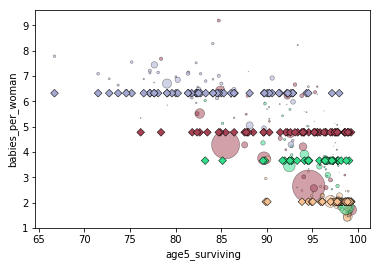

In [28]:
# f_groupmeans
fit = smf.ols(f_groupmeans,gdata).fit()
plotfit(fit,gdata)
cross_validate(gdata,f_groupmeans,'babies_per_woman')

1.0536563721791437

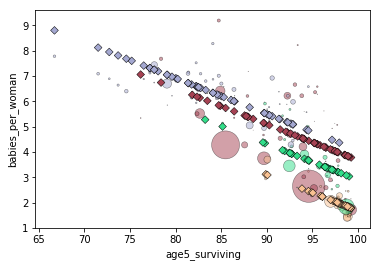

In [9]:
# f_surviving
fit = smf.ols(f_surviving,gdata).fit()
plotfit(fit,gdata)
cross_validate(gdata,f_surviving,'babies_per_woman')

1.151987903994086

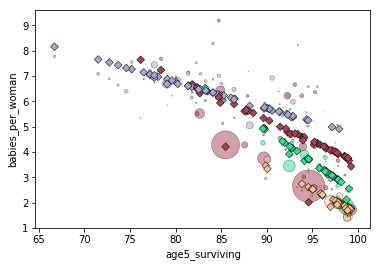

In [29]:
# f_srp
fit = smf.ols(f_srp,gdata).fit()
plotfit(fit,gdata)
cross_validate(gdata,f_srp,'babies_per_woman')

0.9389107520336782

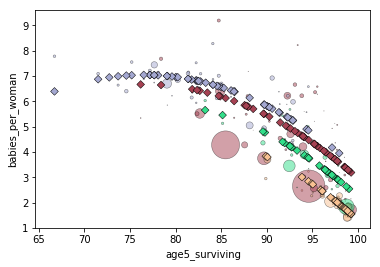

In [32]:
# f_quad 
fit = smf.ols(f_quad,gdata).fit()
plotfit(fit,gdata)
cross_validate(gdata,f_quad,'babies_per_woman')

Cross validation confirms the verdict of analytical goodnes of fit measures. The model of intermediate complexity seems to hit the sweet spot in terms of explanatory power. Adding a squared term gives the lowest mean squared error. 

In theory all data analysts sue k fold cross validation: instead of dividing the data into 2, we divide it in k subsets, then in k successive trials we hold out one of the subsets for testign and trains on all the rest. Finally, the k resulting models are averaged. K fold cross validation is supported in the Python package scikit-learn.

Now let's look at the Bayesian inference by defining the observations to be normally distributed.

In [33]:
gdata.sort_values('age5_surviving', inplace=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [36]:
with pm.Model() as gapminder_context:
    intercept = pm.Uniform('intercept', 5, 15)
    slope = pm.Uniform('slope', -1, 1)
    # Define observations to be normally distributed
    # That is allowing each data value to have a random measurement error
    babies = pm.Normal('babies',
                       mu = intercept + slope * (gdata['age5_surviving'] - 65),
                       sd = 1,
                       observed = gdata['babies_per_woman'])
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [slope, intercept]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:22<00:00, 915.60draws/s] 
The acceptance probability does not match the target. It is 0.8853438035776908, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [37]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
intercept,10.202277,0.283332,0.004210,9.668064,10.784505,4146.119673,1.000033
slope,-0.219553,0.010282,0.000154,-0.240235,-0.199490,4199.153694,1.000016


/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11414a588>,
      dtype=object)

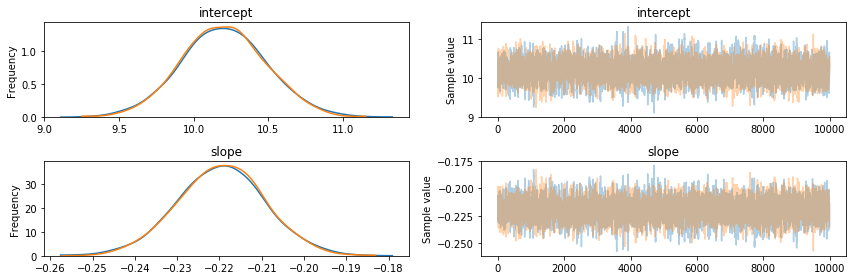

In [38]:
pm.traceplot(trace)

In [39]:
# Evaluated at the mean of the posterior, the model would look like this
# Taking mean values from the posterior and multiply by the explanatory variable
babies = trace['intercept'].mean() + trace['slope'].mean() * (gdata['age5_surviving'] - 65)

Every point in the posterior corresponds to a slightly different model. We can plot them all together to visualize uncertainty. Take every 50th point and also stop the iteration after 100 points. Repeat the calculation of the linear model and plot. And we have the bundle of models within the posterior.

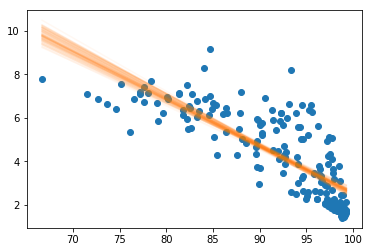

In [40]:
plt.scatter(gdata['age5_surviving'], gdata['babies_per_woman'])

for i, intercept, slope in zip(range(100),trace['intercept'][::50],trace['slope'][::50]):
    babies = intercept + slope * (gdata['age5_surviving'] - 65)
    plt.plot(gdata['age5_surviving'], babies, 'C1', alpha=0.05)